In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import sys
import os
import h5py
import numpy as np

from vit_pytorch import ViT

sys.path.append("/home/lord225/pyrepos/explain-rl")

from ppo import PPO
import procgenwrapper

MODEL_PATH = "/home/lord225/pyrepos/explain-rl/preserve"
DATA_PATH = "/home/lord225/pyrepos/explain-rl/explain/records"

MODEL_NAME = "20250402-092247-StopOpenEarly_6_v3.1"

MODEL_PATH = os.path.join(MODEL_PATH, MODEL_NAME)
DATA_PATH = os.path.join(DATA_PATH, MODEL_NAME+"_replay.h5")

venv = procgenwrapper.ProcGenWrapper("starpilot", human=False, collect_seg=True)

model = PPO.load(MODEL_PATH,
                    env=venv, 
                    print_system_info=True,
                    custom_objects={
                        "ViT":ViT,
                    })

dataset = h5py.File(DATA_PATH, "r")

observations = np.array(dataset["observations"])
actions = np.array(dataset["actions"])
rewards = np.array(dataset["rewards"])
dones = np.array(dataset["dones"])
seg_observations = np.array(dataset["seg_observations"])
next_observations = np.array(dataset["next_observations"])

dataset.close() 

print(observations.shape)

net = model.policy
vit = net.mlp_extractor.policy_net[1]
vit


2025-05-26 20:24:38.700484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-26 20:24:38.700684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-26 20:24:38.722731: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 20:24:38.767107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-26 20:24:39.516785: W tensorflow/compiler/tf2

building procgen...done
== CURRENT SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP Tue Nov 5 00:21:55 UTC 2024
- Python: 3.9.21
- Stable-Baselines3: 2.5.0
- PyTorch: 2.6.0+cu124
- GPU Enabled: True
- Numpy: 1.26.4
- Cloudpickle: 1.2.2
- Gymnasium: 1.0.0
- OpenAI Gym: 0.15.7

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
(50000, 64, 64, 9)


ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=4, p2=4)
    (1): LayerNorm((144,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=144, out_features=64, bias=True)
    (3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.0, inplace=False)
          (to_qkv): Linear(in_features=64, out_features=1152, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=384, out_features=64, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): Layer

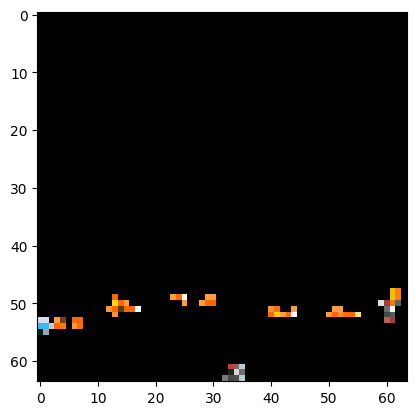

In [2]:
import matplotlib.pyplot as plt

INDEX = 110

plt.imshow(observations[INDEX][:,:,6:])

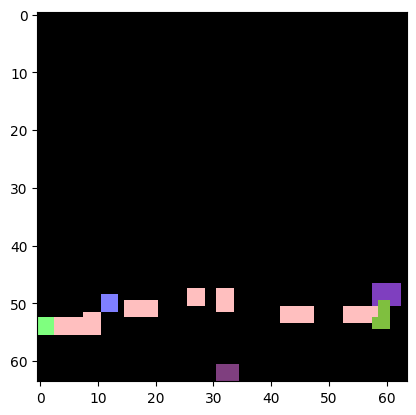

In [3]:
plt.imshow(seg_observations[INDEX][:,:,:])

In [4]:
seg_observations.shape

(50000, 64, 64, 3)

In [5]:
seg_observations.reshape(-1, seg_observations.shape[3]).shape

(204800000, 3)

In [6]:
segment_extractor_path = "./models/data_extractor-full-20250418-212536-WhenFactBe_69_v4.2.pt"
segment_extractor = th.load(segment_extractor_path, weights_only=False)

# get ViT embedding
from vit_pytorch.extractor import Extractor
from vit_pytorch.recorder import Recorder

extractor = Extractor(vit).cpu()
recorder = Recorder(vit).cpu()

In [7]:
import gc
import tqdm

DATASET_SIZE = observations.shape[0]
batch_size = 32

# calculate features using extractor
extractor = extractor.cuda()
features_list = []


with th.no_grad():
    for i in tqdm.tqdm(range(0, DATASET_SIZE, batch_size)):
        batch = th.tensor(observations[i:i+batch_size], device="cpu").permute(0, 3, 1, 2).float().cuda()
        probs, features = extractor(batch)
        features_list.append(features.cpu().detach().numpy())

        del batch
        del features
        del probs
        if i % 1000 == 0:
            th.cuda.empty_cache()
            gc.collect()


features_list = np.concatenate(features_list, axis=0)
print(features_list.shape)

100%|██████████| 1563/1563 [00:15<00:00, 103.97it/s]


(50000, 257, 64)


In [8]:
features_list = features_list[:, 1:].reshape(-1, 16, 16, 64)
features_list.shape

(50000, 16, 16, 64)

In [9]:
segments_list = []

segment_extractor = segment_extractor.cuda()

for i in tqdm.tqdm(range(0, DATASET_SIZE, batch_size)):
    batch = th.tensor(features_list[i:i+batch_size], device="cpu").cuda()
    segments = segment_extractor(batch)
    segments_list.append(segments.cpu().detach().numpy())

    del batch
    del segments
    if i % 1000 == 0:
        th.cuda.empty_cache()
        gc.collect()

segments_list = np.concatenate(segments_list, axis=0)
print(segments_list.shape)


  0%|          | 0/1563 [00:00<?, ?it/s]

100%|██████████| 1563/1563 [00:03<00:00, 422.63it/s]

(50000, 16, 16, 10)


In [10]:
from vit_pytorch.extractor import Extractor
from vit_pytorch.recorder import Recorder

extractor = Extractor(vit).cpu()
recorder = Recorder(vit).cpu()

def attention_map(attention):
    # avg attention over heads
    attention = np.array(attention).mean(axis=1)

    grid_size = int(np.sqrt(attention.shape[-1] - 1))
    num_layers = attention.shape[0]
    num_heads = attention.shape[1]
    reshaped = attention.reshape(
        (num_layers, num_heads, grid_size**2 + 1, grid_size**2 + 1)
    )

    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[1])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Recursively multiply the weight matrices
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])

    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)
    mask = mask / mask.max()
    return mask.reshape(grid_size, grid_size)

In [11]:
observations.shape[0]

50000

In [12]:
from tqdm import tqdm
# calculate attention map for all samples
attention_maps = []
BATCH_SIZE = 2
for i in tqdm(range(0, observations.shape[0], BATCH_SIZE)):
    end = min(i + BATCH_SIZE, observations.shape[0])
    batch_size = end - i
    
    batch_obs = observations[i:end]
    obs_batch = th.tensor(batch_obs).reshape(batch_size, 64, 64, 9).permute(0, 3, 1, 2).float().cpu()
    
    with th.no_grad():
        probas_batch, attention_batch = recorder(obs_batch)
        attention_batch = attention_batch.cpu().detach().numpy()

    for j in range(batch_size):
        attn_map = attention_map(attention_batch[j][np.newaxis])
        attention_maps.append(attn_map)
    
    del obs_batch, probas_batch, attention_batch
    if i % 100 == 0:
        th.cuda.empty_cache()

100%|██████████| 25000/25000 [04:55<00:00, 84.58it/s] 


In [13]:
attention_maps = np.array(attention_maps)
attention_maps.shape

(50000, 16, 16)

In [14]:
POOLER_SMALL = nn.AvgPool2d(kernel_size=2, stride=2)

attention_maps_segmented = []
for i in tqdm(range(len(attention_maps))):
    attention_maps_segmented.append(POOLER_SMALL(th.tensor(attention_maps[i].reshape(16,16,1)).permute(2, 0, 1)).permute(1, 2, 0).numpy())
attention_maps_segmented = np.array(attention_maps_segmented)
attention_maps_segmented.shape

100%|██████████| 50000/50000 [00:01<00:00, 47260.69it/s]


(50000, 8, 8, 1)

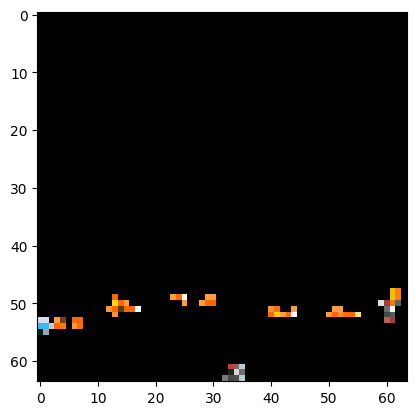

In [15]:
plt.imshow(observations[INDEX][:,:,6:])

In [26]:
# flatten the segmented and attention maps. take 16 features from segmented where attention map is highest.
# Flatten the attention maps for easier indexing


def get_featutures(NO_FEATURES=16):
    num_samples = len(attention_maps_segmented)
    flattened_attention = np.squeeze(attention_maps_segmented, axis=-1).reshape(num_samples, -1)  # Shape: (50000, 256)

    # Create array to store the features
    X = np.zeros((num_samples, NO_FEATURES * 10), dtype=np.float32)
    y = actions  # Using actions as the target variable

    # For each sample, find the 16 positions with highest attention
    for i in range(len(flattened_attention)):
        # Get indices of top 16 attention values
        top_indices = np.argsort(flattened_attention[i])[-NO_FEATURES:]
        
        # Convert flattened indices back to 2D positions
        positions = [(idx // 8, idx % 8) for idx in top_indices]
        
        # Extract the segmented features at those positions and store in X
        feature_idx = 0
        for row, col in positions:
            X[i, feature_idx:feature_idx + 10] = segments_list[i, row, col]
            feature_idx += 10

    return X, y
X, y = get_featutures(NO_FEATURES=3)
X.shape, y.shape


((50000, 30), (50000,))

# Figure out what each class means

In [27]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

In [28]:
print(attention_maps_segmented.shape)
print(attention_maps.shape)

(50000, 8, 8, 1)
(50000, 16, 16)


In [29]:
actions = np.array(actions)

# [4] NOOP
# [5] UP
# [3] DOWN
# [1] LEFT
# [7] RIGHT
# [11] FIRE
# [12] FIRE
# [10] FIRE BACK
# [9]  FIRE 
# other ignored

# collapes actions into 5 classes (UP, DOWN, LEFT, RIGHT, [FIRE, FIRE BACK])
action_map = {
    0: 4,
    1: 1,
    2: 4,
    3: 3,
    4: 4,
    5: 5,
    6: 4,
    7: 7,
    8: 4,
    9: 9,
    10: 9,
    11: 9,
    12: 9,
    13: 4,
    14: 4,
}

# collapse actions
y_collapsed = np.zeros(y.shape, dtype=np.int32)
for i in range(len(y)):
    y_collapsed[i] = action_map[y[i]]

x_collapsed = np.zeros((X.shape[0], X.shape[1]), dtype=np.float32)
for i in range(len(X)):
    x_collapsed[i] = X[i]

y_collapsed_f = y_collapsed[y_collapsed != 4]
x_collapsed_f = x_collapsed[y_collapsed != 4]

y_collapsed_f.shape, x_collapsed_f.shape


((26265,), (26265, 30))

In [30]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

In [ ]:
# train tree now
model = tree.DecisionTreeClassifier(max_leaf_nodes=50, max_depth=5)

X_train, X_test, y_train, y_test = train_test_split(x_collapsed_f, y_collapsed_f, test_size=0.2, random_state=42)

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Report Train")
print(classification_report(y_train, y_pred_train))

Accuracy: 0.7865981343993909
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       154
           3       0.18      0.00      0.01       632
           5       0.00      0.00      0.00       297
           7       0.00      0.00      0.00        32
           9       0.79      1.00      0.88      4138

    accuracy                           0.79      5253
   macro avg       0.19      0.20      0.18      5253
weighted avg       0.64      0.79      0.69      5253

Report Train
              precision    recall  f1-score   support

           1       0.33      0.00      0.00       646
           3       0.83      0.01      0.02      2537
           5       0.00      0.00      0.00      1122
           7       0.00      0.00      0.00       168
           9       0.79      1.00      0.88     16539

    accuracy                           0.79     21012
   macro avg       0.39      0.20      0.18     21012
weighted avg       0.73      0.79  

/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [32]:
def find_best_tree(X_train, y_train):
    model = tree.DecisionTreeClassifier()
    params = {
        'max_depth': [2, 3, 4],
        'max_leaf_nodes': list(range(2, 50)),
    }
    # optimzie f1
    grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose=0, scoring='f1_macro')
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    
    return best_params

params = []
reports=  []
for i in range(1, 10):
    X, y = get_featutures(NO_FEATURES=i)
    y_collapsed = np.zeros(y.shape, dtype=np.int32)
    for i in range(len(y)):
        y_collapsed[i] = action_map[y[i]]

    x_collapsed = np.zeros((X.shape[0], X.shape[1]), dtype=np.float32)
    for i in range(len(X)):
        x_collapsed[i] = X[i]

    y_collapsed_f = y_collapsed[y_collapsed != 4]
    x_collapsed_f = x_collapsed[y_collapsed != 4]   
    
    X_train, X_test, y_train, y_test = train_test_split(x_collapsed_f, y_collapsed_f, test_size=0.2, random_state=42)

    best_params = find_best_tree(x_collapsed_f, y_collapsed_f)
    model = tree.DecisionTreeClassifier(**best_params)
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    reports.append(report)
    params.append(best_params)
    print("Accuracy:", accuracy_score(y_test, y_pred), best_params)

Accuracy: 0.78697886921759 {'max_depth': 4, 'max_leaf_nodes': 17}
Accuracy: 0.7871692366266895 {'max_depth': 4, 'max_leaf_nodes': 24}
Accuracy: 0.7871692366266895 {'max_depth': 4, 'max_leaf_nodes': 11}
Accuracy: 0.78697886921759 {'max_depth': 4, 'max_leaf_nodes': 10}
Accuracy: 0.7873596040357891 {'max_depth': 4, 'max_leaf_nodes': 12}
Accuracy: 0.7873596040357891 {'max_depth': 4, 'max_leaf_nodes': 11}
Accuracy: 0.7877403388539882 {'max_depth': 4, 'max_leaf_nodes': 11}
Accuracy: 0.78697886921759 {'max_depth': 4, 'max_leaf_nodes': 13}
Accuracy: 0.785646297353893 {'max_depth': 4, 'max_leaf_nodes': 12}


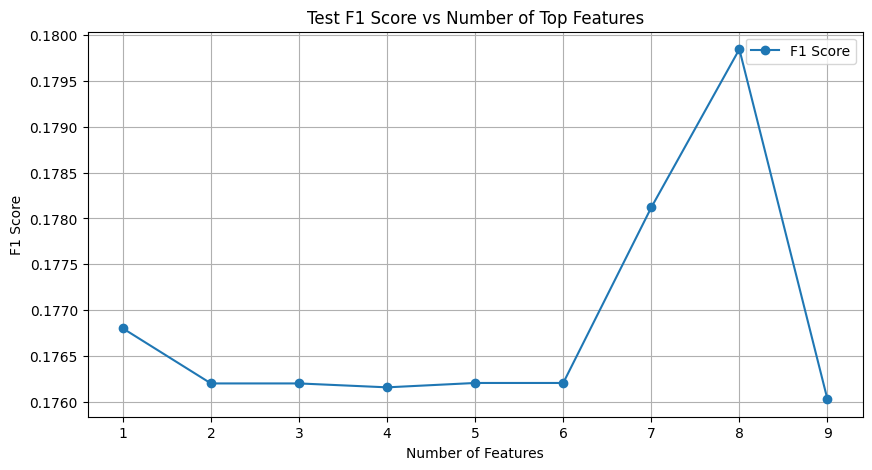

In [33]:
# plot f1
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(reports)+1), [report["macro avg"]["f1-score"] for report in reports], label="F1 Score", marker='o')
plt.xlabel("Number of Features")
plt.ylabel("F1 Score")
plt.title("Test F1 Score vs Number of Top Features")
plt.legend()
plt.grid()
plt.show()

In [24]:
def find_best_tree(X_train, y_train):
    model = tree.DecisionTreeClassifier()
    params = {
        'max_depth': [2, 3, 4, 5],
        'max_leaf_nodes': list(range(2, 50)),
        'min_samples_split': [1, 2, 3, 4],
        'min_samples_leaf': [1, 2, 3, 4],
    }
    grid_search = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    
    return best_params

params = []
reports=  []
for i in range(1, 4):
    X, y = get_featutures(NO_FEATURES=i)
    y_collapsed = np.zeros(y.shape, dtype=np.int32)
    for i in range(len(y)):
        y_collapsed[i] = action_map[y[i]]

    x_collapsed = np.zeros((X.shape[0], X.shape[1]), dtype=np.float32)
    for i in range(len(X)):
        x_collapsed[i] = X[i]

    y_collapsed_f = y_collapsed[y_collapsed != 4]
    x_collapsed_f = x_collapsed[y_collapsed != 4]   
    
    X_train, X_test, y_train, y_test = train_test_split(x_collapsed_f, y_collapsed_f, test_size=0.2, random_state=42)

    best_params = find_best_tree(x_collapsed_f, y_collapsed_f)
    model = tree.DecisionTreeClassifier(**best_params)
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    reports.append(report)
    params.append(best_params)
    print("Accuracy:", accuracy_score(y_test, y_pred), best_params)

/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3840 fits failed out of a total of 15360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3840 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
    vali

Accuracy: 0.7877403388539882 {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3840 fits failed out of a total of 15360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3840 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/base.py", line 436, in _validate_params
    vali

Accuracy: 0.7877403388539882 {'max_depth': 2, 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


KeyboardInterrupt: 

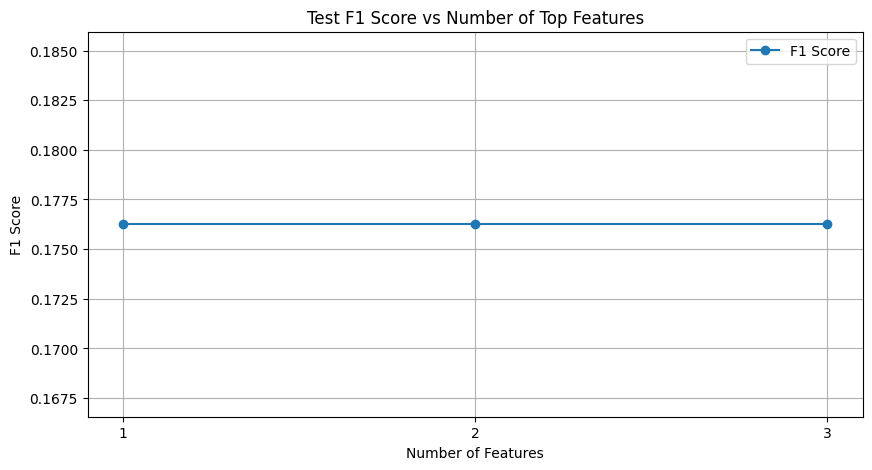

In [ ]:
# plot f1
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(reports)+1), [report["macro avg"]["f1-score"] for report in reports], label="F1 Score", marker='o')
plt.xlabel("Number of Features")
plt.ylabel("F1 Score")
plt.title("Test F1 Score vs Number of Top Features")
plt.legend()
plt.grid()
plt.xticks(range(1, len(reports)+1))
plt.show()

In [ ]:
params[1]

{'max_depth': 2,
 'max_leaf_nodes': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [ ]:
X, y = get_featutures(NO_FEATURES=2)

# UP/DOWN NONE dataset
action_map = {
    0: 4,
    1: 4,
    2: 4,
    3: 3,
    4: 4,
    5: 5,
    6: 4,
    7: 4,
    8: 4,
    9: 4,
    10: 4,
    11: 4,
    12: 4,
    13: 4,
    14: 4,
}
y_collapsed = np.zeros(y.shape, dtype=np.int32)
for i in range(len(y)):
    y_collapsed[i] = action_map[y[i]]

x_collapsed = np.zeros((X.shape[0], X.shape[1]), dtype=np.float32)
for i in range(len(X)):
    x_collapsed[i] = X[i]

X_train_UPDOWN, X_test_UPDOWN, y_train_UPDOWN, y_test_UPDOWN = train_test_split(x_collapsed, y_collapsed, test_size=0.2, random_state=42)
from sklearn.utils.class_weight import compute_class_weight
class_weights_up_down = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_up_down = {
    3: class_weights_up_down[0],
    4: class_weights_up_down[1]/10,
    5: class_weights_up_down[2],
}
class_weights_up_down

{3: 6.505263157894737, 4: 0.16564446196294838, 5: 3.7454545454545456}

(2) Accuracy: 0.0653
(3) Accuracy: 0.0653
(4) Accuracy: 0.0653
(5) Accuracy: 0.0653
(6) Accuracy: 0.0653
(7) Accuracy: 0.0653
(8) Accuracy: 0.0653
(9) Accuracy: 0.0653
(10) Accuracy: 0.0653
(11) Accuracy: 0.0653
(12) Accuracy: 0.0653
(13) Accuracy: 0.0653
(14) Accuracy: 0.0653
(15) Accuracy: 0.0653


Text(0.5, 1.0, 'Accuracy vs Max Leaf Nodes')

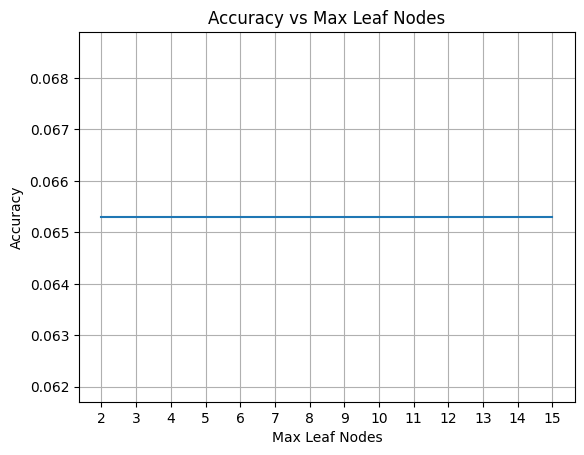

In [ ]:
accs = []
for i in range(2, 16):
    model = tree.DecisionTreeClassifier(
        class_weight=class_weights_up_down,
        max_leaf_nodes=i,
        min_samples_split=1000,
        min_samples_leaf=1100,
    )

    model = model.fit(X_train_UPDOWN, y_train_UPDOWN)
    y_pred_UPDOWN = model.predict(X_test_UPDOWN)
    y_pred_train_UPDOWN = model.predict(X_train_UPDOWN)
    print(f"({i}) Accuracy:", accuracy_score(y_test_UPDOWN, y_pred_UPDOWN))
    accs.append(accuracy_score(y_test_UPDOWN, y_pred_UPDOWN))
# print(classification_report(y_test_UPDOWN, y_pred_UPDOWN))
# print("Report Train")
# print(classification_report(y_train_UPDOWN, y_pred_train_UPDOWN))

plt.plot(range(2, 16), accs)
plt.xticks(range(2, 16))
plt.grid()
plt.xlabel("Max Leaf Nodes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Max Leaf Nodes")

In [ ]:
model = tree.DecisionTreeClassifier(
    class_weight=class_weights_up_down,
    max_leaf_nodes=8,
    min_samples_split=1000,
    min_samples_leaf=1100,
)

model = model.fit(X_train_UPDOWN, y_train_UPDOWN)
y_pred_UPDOWN = model.predict(X_test_UPDOWN)
y_pred_train_UPDOWN = model.predict(X_train_UPDOWN)
print(f"Accuracy:", accuracy_score(y_test_UPDOWN, y_pred_UPDOWN))
accs.append(accuracy_score(y_test_UPDOWN, y_pred_UPDOWN))
print(classification_report(y_test_UPDOWN, y_pred_UPDOWN))
print("Report Train")
print(classification_report(y_train_UPDOWN, y_pred_train_UPDOWN))


Accuracy: 0.0653
              precision    recall  f1-score   support

           3       0.07      1.00      0.12       653
           4       0.00      0.00      0.00      9043
           5       0.00      0.00      0.00       304

    accuracy                           0.07     10000
   macro avg       0.02      0.33      0.04     10000
weighted avg       0.00      0.07      0.01     10000

Report Train
              precision    recall  f1-score   support

           3       0.06      1.00      0.12      2516
           4       0.00      0.00      0.00     36369
           5       0.00      0.00      0.00      1115

    accuracy                           0.06     40000
   macro avg       0.02      0.33      0.04     40000
weighted avg       0.00      0.06      0.01     40000



/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lord225/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [ ]:
# visualize tree
import matplotlib.pyplot as plt

import graphviz


def get(name):
    # get names of 10 features from prev list
    return [f'{name}_{features_name}' for features_name in features_names] 

features_names_all = get("1st") + get("2nd")
target_names = ["NOOP", "UP", "DOWN", "LEFT", "RIGHT", "FIRE"]
# DOT data
dot_data = tree.export_graphviz(model, out_file=None,
                                class_names=target_names,
                                feature_names=features_names_all,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, filename=None, format="png")
graph

NameError: name 'features_names' is not defined

Text(0.5, 1.0, 'Feature Importance')

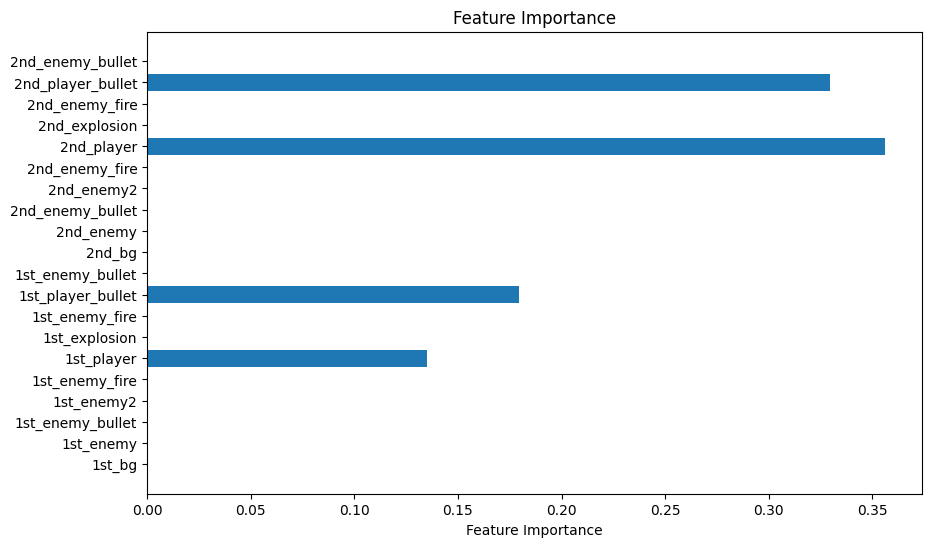

In [ ]:

# feature importance
importances = model.feature_importances_
indices = np.where(importances > 0)[0]
# Plot the feature importances of the forest
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), features_names_all)
plt.xlabel('Feature Importance')
plt.title('Feature Importance')



In [ ]:
model = tree.DecisionTreeClassifier(
    class_weight=class_weights_up_down,
)

model = model.fit(X_train_UPDOWN, y_train_UPDOWN)
y_pred_UPDOWN = model.predict(X_test_UPDOWN)
y_pred_train_UPDOWN = model.predict(X_train_UPDOWN)
print(f"Accuracy:", accuracy_score(y_test_UPDOWN, y_pred_UPDOWN))
accs.append(accuracy_score(y_test_UPDOWN, y_pred_UPDOWN))
print(classification_report(y_test_UPDOWN, y_pred_UPDOWN))
print("Report Train")
print(classification_report(y_train_UPDOWN, y_pred_train_UPDOWN))


Accuracy: 0.4357
              precision    recall  f1-score   support

           3       0.08      0.55      0.13       653
           4       0.92      0.43      0.59      9043
           5       0.08      0.25      0.12       304

    accuracy                           0.44     10000
   macro avg       0.36      0.41      0.28     10000
weighted avg       0.84      0.44      0.55     10000

Report Train
              precision    recall  f1-score   support

           3       0.13      0.98      0.23      2516
           4       1.00      0.47      0.64     36369
           5       0.17      0.60      0.27      1115

    accuracy                           0.51     40000
   macro avg       0.43      0.68      0.38     40000
weighted avg       0.92      0.51      0.61     40000



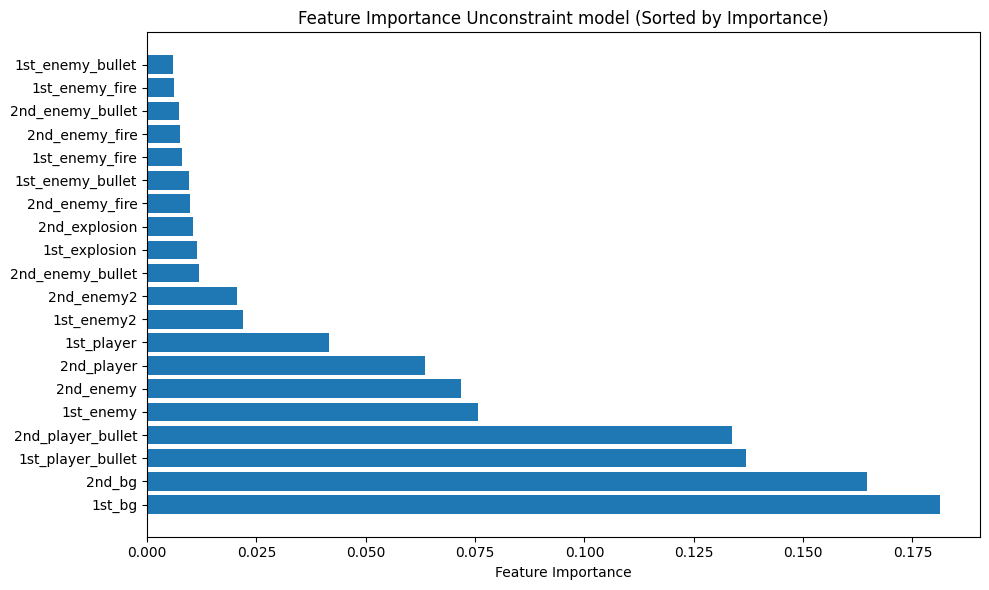

In [ ]:
# feature importance
importances = model.feature_importances_

# Create a sorted version of the plot
sorted_idx = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[sorted_idx], align='center')
plt.yticks(range(len(importances)), np.array(features_names_all)[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Unconstraint model (Sorted by Importance)')
plt.tight_layout()
